<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/simple_gan_3class_invert_regularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

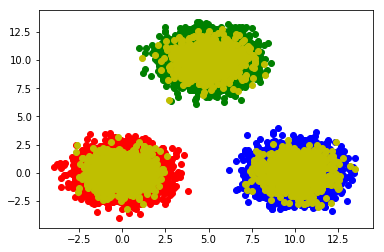

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

tf.reset_default_graph()
tf.set_random_seed(1)

# Training Params
num_steps = 100000
learning_rate = 0.00002
x_dim = 2
noise_dim = 20
NUM_LABEL = 3
GAN_CLASS_COE = 10
gan_batch_size = 100*NUM_LABEL
num_data = 10000
INV_HIDDEN = 100
beta = 1
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), dtype=tf.float32)
 
# Linear Regression 
class Generator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL, batch_size):
    self.batch_size = batch_size
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(tf.zeros([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(tf.zeros([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(tf.zeros([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class Disciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(tf.zeros([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(tf.zeros([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out

class Classifier(object):
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim, NUM_LABEL]))
    self.linear_b1 = tf.Variable(tf.zeros([NUM_LABEL]))
    self.linear_w2 = tf.Variable(glorot_init([1, NUM_LABEL]))
    self.linear_b2 = tf.Variable(tf.zeros([NUM_LABEL]))

    self.training = True

  # Build D Graph
  def __call__(self, x):
#     linear1 = tf.nn.relu(tf.matmul(x, self.linear_w1) + self.linear_b1)
#     out = tf.nn.softmax(tf.matmul(linear1, self.linear_w2) + self.linear_b2)
    out = tf.nn.softmax(tf.matmul(x, self.linear_w1) + self.linear_b1)
    return out
  
def lrelu(x, alpha):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

class Inverter_Regularizer(object):
  def __init__(self, weight_shape):
    self.w_model =  tf.Variable(glorot_init([weight_shape, INV_HIDDEN]))
    self.w_label = tf.Variable(glorot_init([NUM_LABEL, INV_HIDDEN]))
    self.w_out = tf.Variable(glorot_init([INV_HIDDEN, x_dim]))
    self.b_in = tf.Variable(tf.zeros([INV_HIDDEN]))
    self.b_out = tf.Variable(tf.zeros([x_dim]))
    
  def __call__(self, y, model_weights):
    # Input Layer
    ww = tf.matmul(model_weights, self.w_model)
    wy = tf.matmul(y, self.w_label)
    wt = tf.add(wy, ww)
    hidden_layer =  tf.add(wt, self.b_in)
    rect = lrelu(hidden_layer, 0.3)
    # Output Layer
    out_layer = tf.add(tf.matmul(rect, self.w_out), self.b_out)
    rect = lrelu(out_layer, 0.3)
    return rect
  
def plot_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(NUM_LABEL):   
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:, i] = 1
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([gen_sample], feed_dict={gen_input: z, desired_label: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    elif i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
    elif i == 2:
      ax.scatter(g[:,0], g[:,1], c='g')
     
  # f.show()
  plt.savefig(name+epoch)
#   plt.close()

###################### Build Dataset #############################
features = tf.placeholder(tf.float32, shape=[None, x_dim])
labels = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
batch_size = tf.placeholder(tf.int64)
sample_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(sample_size, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

mu1 = [0., 0.]
sigma1 = [[1., 0.], [0., 1.]]
mu2 = [10., 0.]
sigma2 = [[1., 0.], [0., 1.]]
mu3 = [5., 10.]
x_1 = np.random.multivariate_normal(mu1, sigma1, num_data)
x_2 = np.random.multivariate_normal(mu2, sigma1, num_data)
x_3 = np.random.multivariate_normal(mu3, sigma1, num_data)

plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.scatter(x_2[:,0], x_2[:,1], c='b')
plt.scatter(x_3[:,0], x_3[:,1], c='g')

# !label=3
x_train = np.concatenate((x_1, x_2, x_3), axis=0)
y_train = np.zeros([num_data*NUM_LABEL, NUM_LABEL])
for i in range(NUM_LABEL):
  y_train[i*num_data:(i+1)*num_data, i] = 1.
  
#aux_data is same as data1
aux_mu1 = [0., 0.]
aux_mu2 = [50., 0.]
aux_mu3 = [0., 0.]

aux_data1 = np.random.multivariate_normal(mu1, sigma1, 1000)
aux_data2 = np.random.multivariate_normal(mu2, sigma1, 1000)
aux_data3 = np.random.multivariate_normal(mu3, sigma1, 1000)

aux_data = np.concatenate((aux_data1, aux_data2, aux_data3), axis=0)
# random.shuffle(aux_data)
plt.scatter(aux_data[:,0], aux_data[:,1], c='y')


################### Build The Classifier ####################
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
model = Classifier()
y_ml = model(x)
# Build Inverter Regularizer
model_weights = tf.concat([tf.reshape(model.linear_w1,[1, -1]),tf.reshape(model.linear_b1,[1, -1])] ,1) #, tf.reshape(model.linear_w2,[1, -1]), tf.reshape(model.linear_b2,[1, -1])], 1)
weight_shape = int(model_weights.shape[1])
inverter = Inverter_Regularizer(weight_shape)
inv_x = inverter(y, model_weights)

# Calculate MODEL Loss
inv_loss = tf.losses.mean_squared_error(labels=x, predictions=inv_x)
class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_ml))
model_loss = class_loss - beta * inv_loss
y_pred = tf.argmax(y_ml, 1)
correct = tf.equal(tf.argmax(y_ml, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Build Optimizer !Use model_loss
model_optimizer = tf.train.AdamOptimizer(0.001).minimize(model_loss, var_list=[model.linear_w1, model.linear_b1])#, model.linear_w2, model.linear_b2])
inverter_optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(inv_loss, var_list=[inverter.w_model, inverter.w_label, inverter.w_out, inverter.b_in, inverter.b_out])
grad_model = tf.gradients(class_loss, [model.linear_w1, model.linear_b1])#, model.linear_w2, model.linear_b2])
#################### Build GAN Networks ############################
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
aux_x = tf.placeholder(tf.float32, shape=[None, x_dim])
aux_label = model(aux_x)
desired_label = tf.one_hot(tf.argmax(aux_label, 1), NUM_LABEL) 

# Build G Network
G = Generator(noise_dim, NUM_LABEL, gan_batch_size)
gen_sample = G(gen_input,desired_label)
gen_label =  model(gen_sample)

# Build 2 D Networks (one from noise input, one from generated samples)
D = Disciminator()
disc_real = D(aux_x, desired_label)
disc_fake = D(gen_sample, desired_label)

# Build Loss
gan_class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=desired_label, logits=gen_label))
gen_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, disc_fake))) + GAN_CLASS_COE*gan_class_loss
disc_loss = -tf.reduce_mean(tf.log(tf.maximum(0.0000001, disc_real)) + tf.log(tf.maximum(0.0000001, 1. - disc_fake)))

# G Network Variables
gen_vars = [G.linear_w1, G.linear_b1, G.linear_w2, G.linear_b2, G.linear_w3, G.linear_b3]
# D Network Variables
disc_vars = [D.linear_w1, D.linear_b1, D.linear_w2, D.linear_b2]

# Create training operations
train_gen = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_loss, var_list=gen_vars)
train_disc = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(disc_loss, var_list=disc_vars)


Epoch 0, training accuracy 0.476667
Epoch 500, training accuracy 0.443333
Epoch 1000, training accuracy 0.476667
Epoch 1500, training accuracy 0.5
Epoch 2000, training accuracy 0.543333
Epoch 2500, training accuracy 0.65
Epoch 3000, training accuracy 0.653333
Epoch 3500, training accuracy 1
test acc: 0.9996333
cluster1:  (9989, 2) cluster2:  (10006, 2) cluster3: (10005, 2)
Epoch 0: Generator Loss: 12.558229, Discriminator Loss: 5.901282
Epoch 2000: Generator Loss: 10.497501, Discriminator Loss: 0.854993
Epoch 4000: Generator Loss: 7.102034, Discriminator Loss: 1.134722
Epoch 6000: Generator Loss: 6.505472, Discriminator Loss: 1.330751
Epoch 8000: Generator Loss: 6.520741, Discriminator Loss: 1.382094
Epoch 10000: Generator Loss: 6.516427, Discriminator Loss: 1.318807
Epoch 12000: Generator Loss: 6.485138, Discriminator Loss: 1.309887
Epoch 14000: Generator Loss: 6.512556, Discriminator Loss: 1.325793
Epoch 16000: Generator Loss: 6.490629, Discriminator Loss: 1.254954
Epoch 18000: Gener

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 40000: Generator Loss: 6.499378, Discriminator Loss: 1.304779
Epoch 42000: Generator Loss: 6.481906, Discriminator Loss: 1.363441
Epoch 44000: Generator Loss: 6.558533, Discriminator Loss: 1.360708
Epoch 46000: Generator Loss: 6.517733, Discriminator Loss: 1.414141
Epoch 48000: Generator Loss: 6.415554, Discriminator Loss: 1.286602
Epoch 50000: Generator Loss: 6.496602, Discriminator Loss: 1.278474
Epoch 52000: Generator Loss: 6.504630, Discriminator Loss: 1.269810
Epoch 54000: Generator Loss: 6.543392, Discriminator Loss: 1.315567
Epoch 56000: Generator Loss: 6.495006, Discriminator Loss: 1.298032
Epoch 58000: Generator Loss: 6.457450, Discriminator Loss: 1.314678
Epoch 60000: Generator Loss: 6.494933, Discriminator Loss: 1.312288
Epoch 62000: Generator Loss: 6.544096, Discriminator Loss: 1.255532
Epoch 64000: Generator Loss: 6.524188, Discriminator Loss: 1.444713
Epoch 66000: Generator Loss: 6.522371, Discriminator Loss: 1.306434
Epoch 68000: Generator Loss: 6.505599, Discrimin

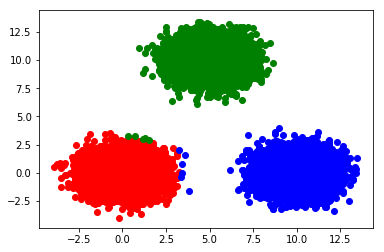

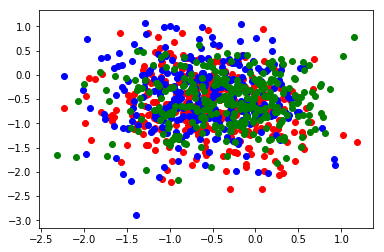

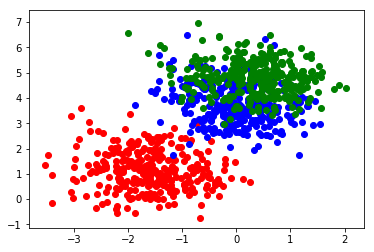

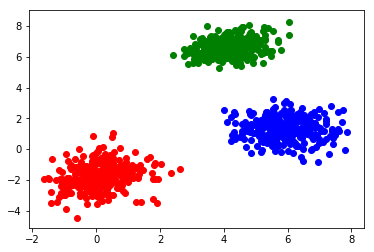

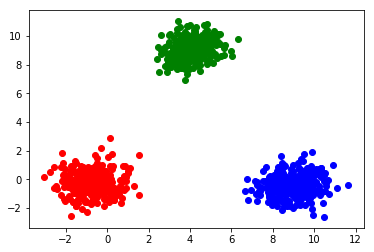

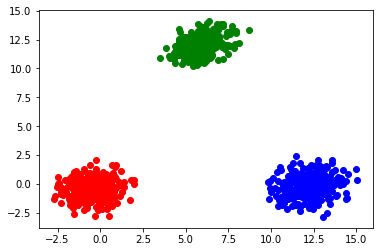

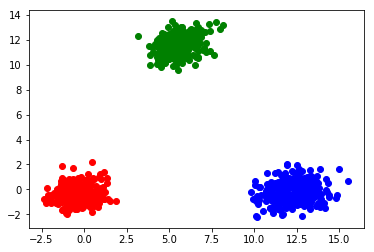

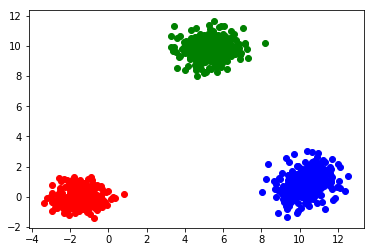

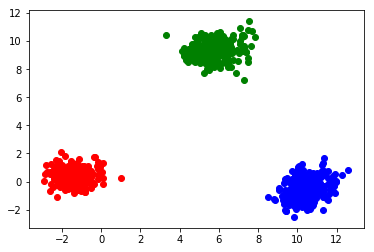

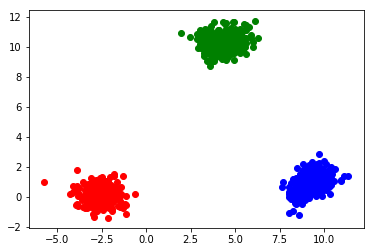

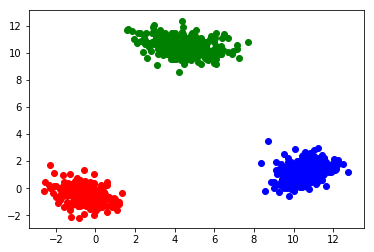

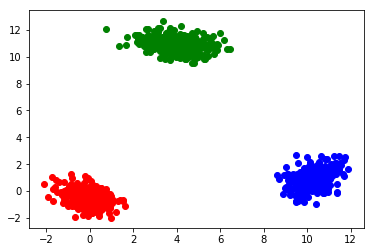

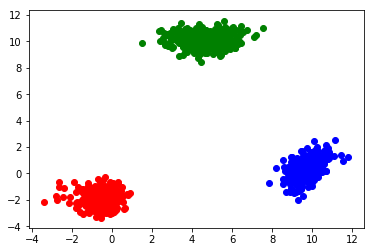

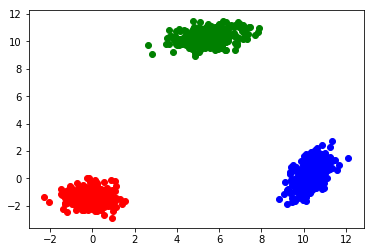

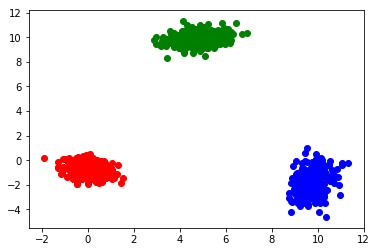

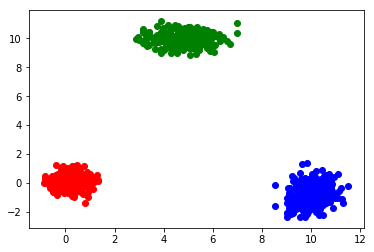

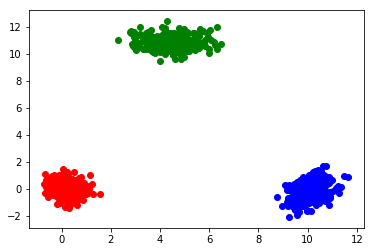

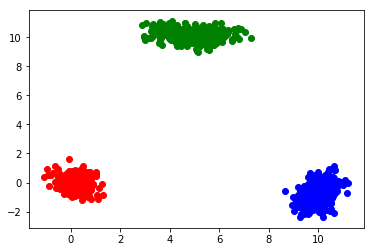

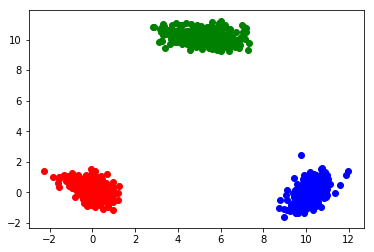

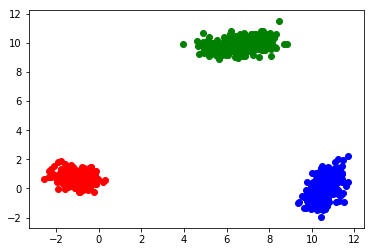

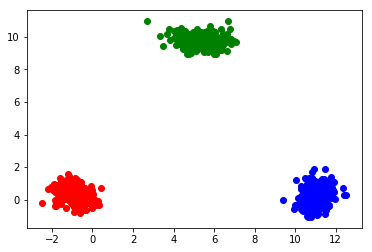

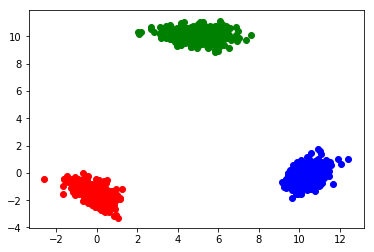

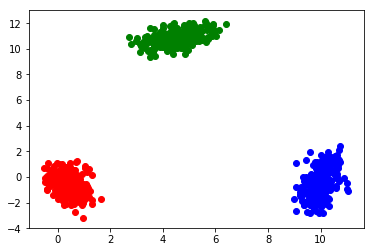

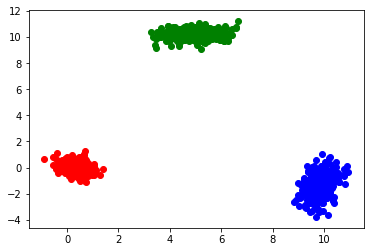

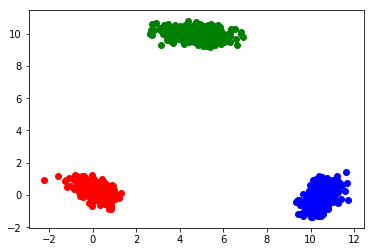

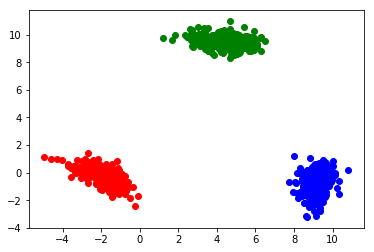

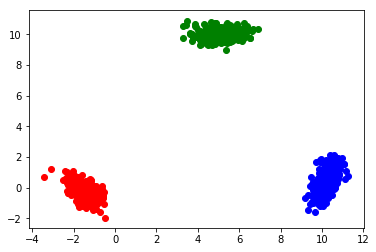

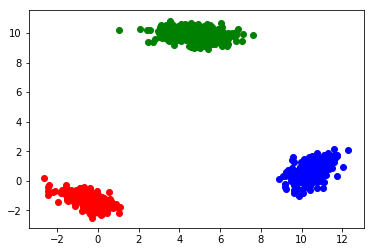

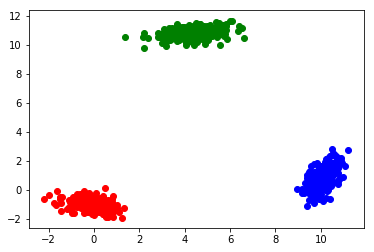

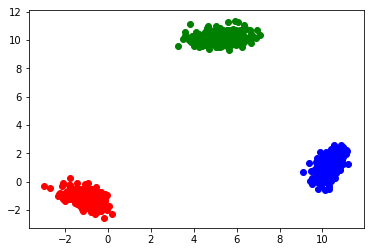

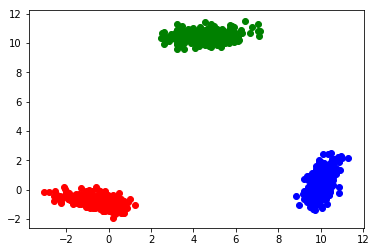

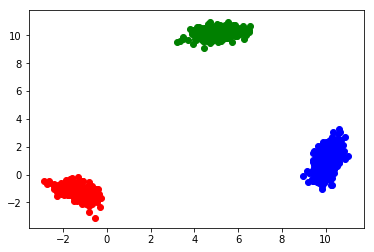

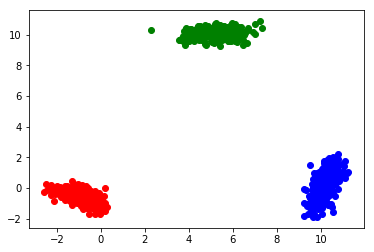

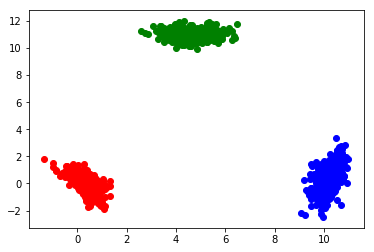

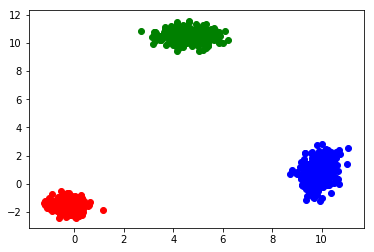

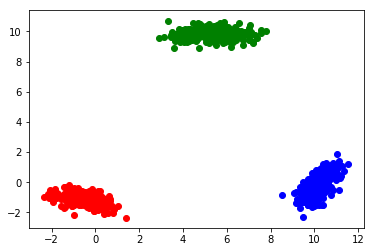

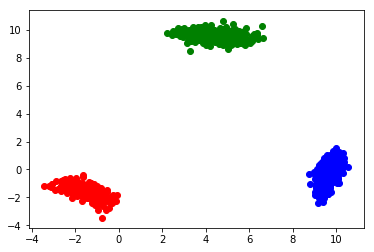

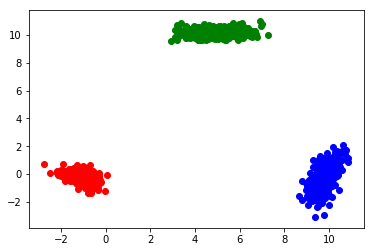

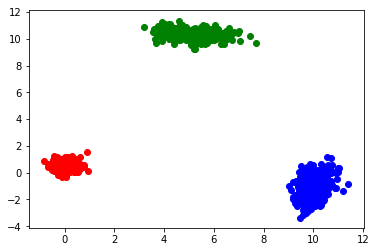

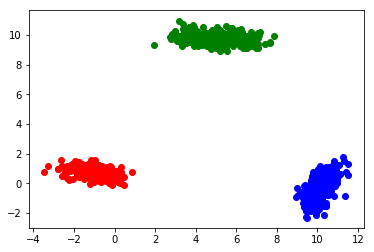

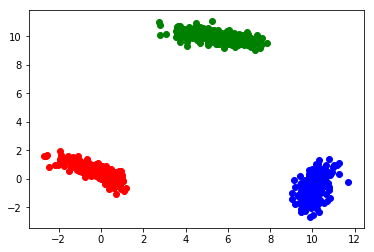

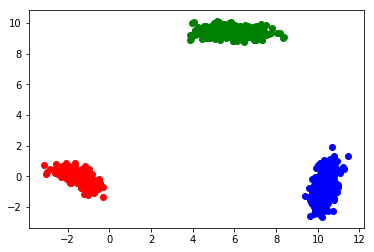

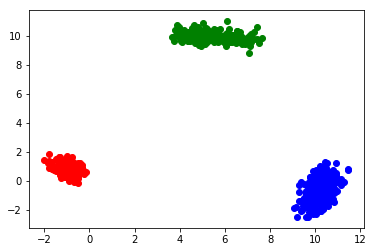

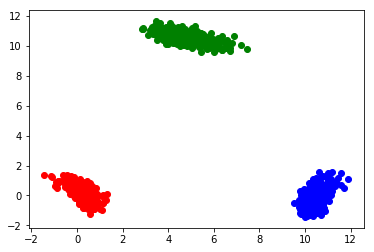

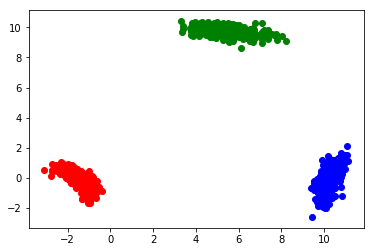

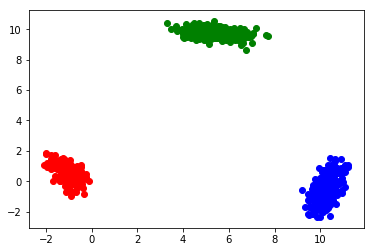

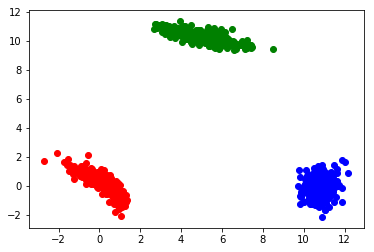

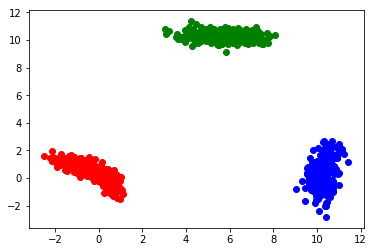

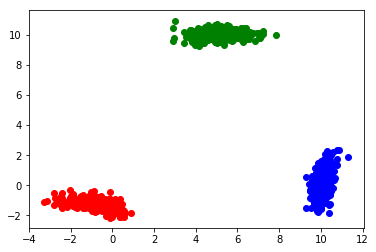

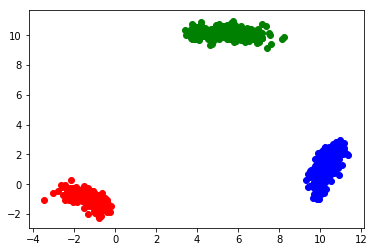

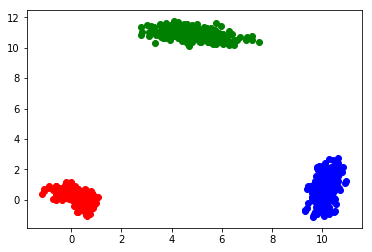

In [13]:
def train_gan():
  # Train Classifier
  
  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.Session() as sess:

      # Run the initializer
      sess.run(init)

      sess.run(iterator.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: gan_batch_size, sample_size: 40000})

      # Train the Classifier First
      for i in range(4000):
        batch = sess.run(next_batch)
        model_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        inverter_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        if i % 500 == 0:
          gradients, train_accuracy = sess.run([grad_model, accuracy], feed_dict={x: batch[0], y: batch[1] })
#           print('gradients: ', gradients)
          print('Epoch %d, training accuracy %g' % (i, train_accuracy))    

      test_acc, y_prediction = sess.run([accuracy, y_pred], feed_dict={x: x_train, y: y_train})
      print("test acc:", test_acc)

      cluster1 = []
      cluster2 = []
      cluster3 = []
      for i in range(0, num_data*NUM_LABEL):
        if y_prediction[i] == 0:
          cluster1.append(x_train[i])
        elif y_prediction[i] == 1:
          cluster2.append(x_train[i])
        else:
          cluster3.append(x_train[i])

      cluster1 = np.array(cluster1)
      cluster2 = np.array(cluster2)
      cluster3 = np.array(cluster3)
      print('cluster1: ', cluster1.shape, 'cluster2: ', cluster2.shape, 'cluster3:', cluster3.shape)
      plt.scatter(cluster1[:,0], cluster1[:,1],c='r')
      plt.scatter(cluster2[:,0], cluster2[:,1],c='b')
      plt.scatter(cluster3[:,0], cluster3[:,1],c='g')
      plt.savefig('Classifier_plot')
      
      # no need
      aux_label = np.zeros([1000*NUM_LABEL, NUM_LABEL])
      sess.run(iterator.initializer, feed_dict = {features: aux_data, labels: aux_label, batch_size: gan_batch_size, sample_size: 40000})
      #Train GAN
      for i in range(100000):      
        # Sample random noise 
        batch = sess.run(next_batch)
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
        #! Train Discriminator
        train_disc.run(feed_dict={aux_x: batch[0],  gen_input: z})
#         if i % 5 == 0:
        train_gen.run(feed_dict={aux_x: batch[0],  gen_input: z})
       
        if i % 2000 == 0:
          gl,dl = sess.run([gen_loss, disc_loss], feed_dict={aux_x: batch[0],  gen_input: z})
          print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
          plot_gan_image('gan_out',str(i), sess)
      
      
if __name__ == '__main__':
  train_gan()